In [136]:
# https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action#qiskit-implementation

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random
from qiskit.quantum_info import Statevector, Operator, partial_trace


# Quantum teleportation protocol

/Users/leecostello/Documents/code/lee/quantum-workbook/venv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


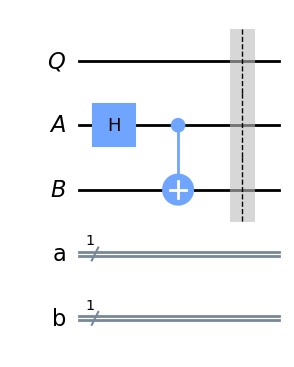

'System-wide state vector: |BAQ>'

<IPython.core.display.Latex object>

'density matrix for state of qubit B'

<IPython.core.display.Latex object>

'density matrix for state of qubit A'

<IPython.core.display.Latex object>

'density matrix for state of qubit Q'

<IPython.core.display.Latex object>

In [137]:
qubit = QuantumRegister(1, "Q") # index 2
ebit0 = QuantumRegister(1, "A") # index 1
ebit1 = QuantumRegister(1, "B") # index 0
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

def display_circuit():
  display(protocol.draw("mpl"))

  # Simulate statevector for the entire circuit
  state = Statevector.from_instruction(protocol)
  display("System-wide state vector: |BAQ>", state.draw('latex'))

  # extract statevector for qubit B
  state_b = partial_trace(state, [0, 1])
  display("density matrix for state of qubit B", state_b.draw('latex'))

  # extract statevector for qubit A
  state_a = partial_trace(state, [0, 2])
  display("density matrix for state of qubit A", state_a.draw('latex'))

  # extract statevector for qubit Q
  state_q = partial_trace(state, [1, 2])
  display("density matrix for state of qubit Q", state_q.draw('latex'))

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

display_circuit()


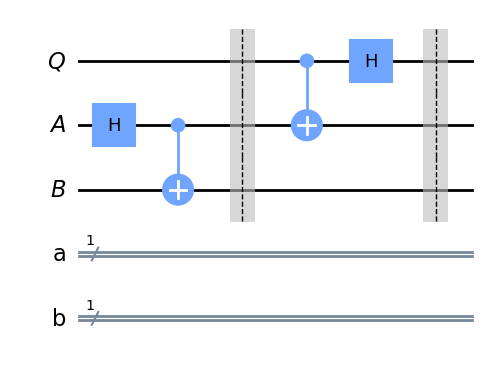

'System-wide state vector: |BAQ>'

<IPython.core.display.Latex object>

'density matrix for state of qubit B'

<IPython.core.display.Latex object>

'density matrix for state of qubit A'

<IPython.core.display.Latex object>

'density matrix for state of qubit Q'

<IPython.core.display.Latex object>

In [138]:
# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

display_circuit()


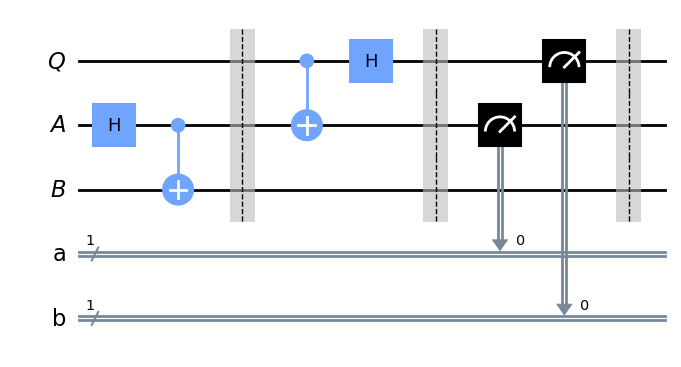

In [139]:
# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

display(protocol.draw("mpl"))

# can no longer display state vectors because measurements collapsed two of the qubits


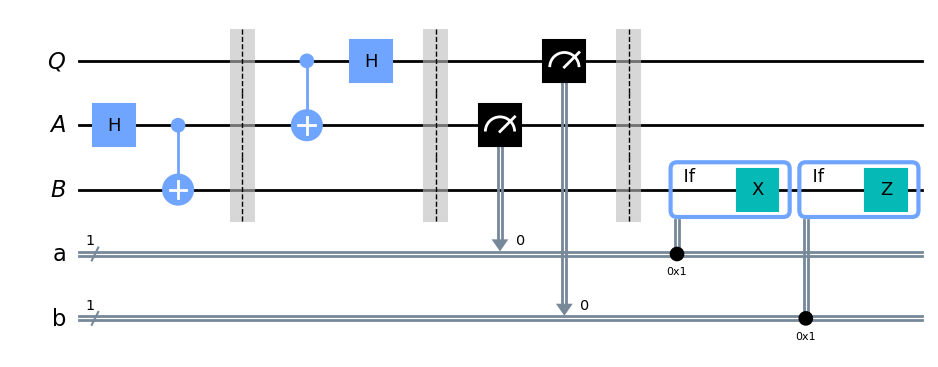

In [140]:
# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
  protocol.x(ebit1)
with protocol.if_test((b, 1)):
  protocol.z(ebit1)

display(protocol.draw("mpl"))


### test that the teleportation protocol works correctly

In [141]:
# randomly choose a unitary qubit gate
random_gate = UGate(
  theta=random.random() * 2 * pi,
  phi=random.random() * 2 * pi,
  lam=random.random() * 2 * pi
)

display(random_gate.to_matrix())


array([[-0.17168591+0.j        ,  0.9622122 -0.21135664j],
       [ 0.94525663-0.27751369j,  0.15052142-0.08257939j]])

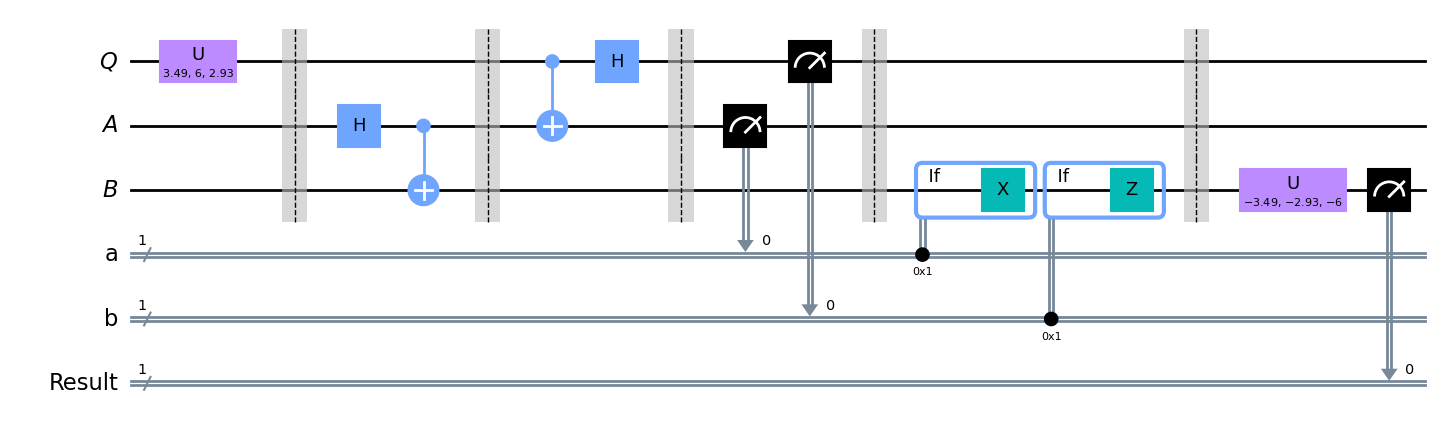

In [142]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q
test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above
test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure
test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw("mpl"))


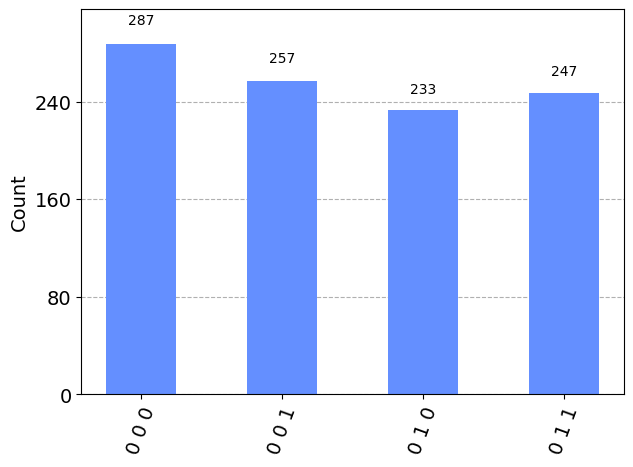

In [143]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))


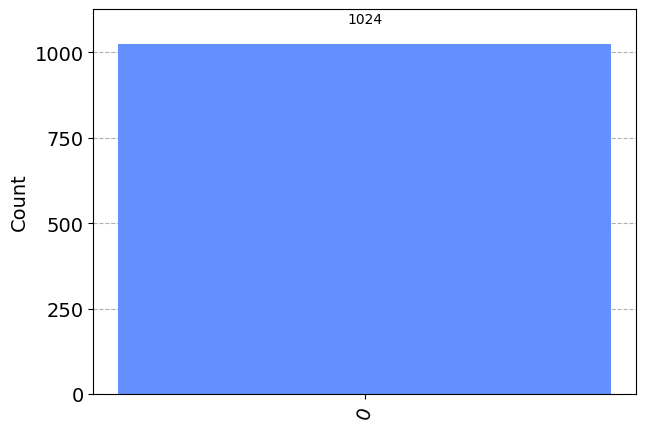

In [144]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))
